In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [70]:
df1 = pd.read_csv('movies_5000_credits.csv')

In [71]:
df2 = pd.read_csv('movies_5000.csv')

In [72]:
# Renaming the columns in the credits dataset

df1.columns = ['id','tittle','cast','crew']

In [73]:
# Merging the two datasets on column 'id'

df2 = df2.merge(df1, on = 'id')

In [74]:
# weighted rating(w) = (v/(v+m) * r) + (m/(v + m) * c)
# v - number of votes for that movie
# m - minimum number of required votes
# r - average rating of that movie
# c - mean vote across the whole report

In [75]:
c = df2['vote_average'].mean()

In [76]:
# mean rating
c

6.092171559442011

In [77]:
m = df2['vote_count'].quantile(0.9)

In [78]:
# minimum number of votes
m

1838.4000000000015

In [79]:
# movies that are qualified with above condition
q_movies = df2.copy().loc[df2['vote_count'] >= m]

In [80]:
q_movies.shape

(481, 23)

In [81]:
def weighted_rating(x, m=m, c=c):
    v = x['vote_count']
    r = x['vote_average']
    
    return (v/(v+m) * r) + (m/(v + m) * c)

In [82]:
q_movies['score'] = q_movies.apply(weighted_rating, axis = 1)

In [83]:
q_movies = q_movies.sort_values('score', ascending = False)

In [84]:
q_movies[['title', 'vote_count', 'vote_average', 'score']]

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
...,...,...,...,...
41,Green Lantern,2487,5.1,5.521697
337,A Good Day to Die Hard,3493,5.2,5.507643
193,After Earth,2532,5.0,5.459420
91,Independence Day: Resurgence,2491,4.9,5.406234


<function matplotlib.pyplot.show(close=None, block=None)>

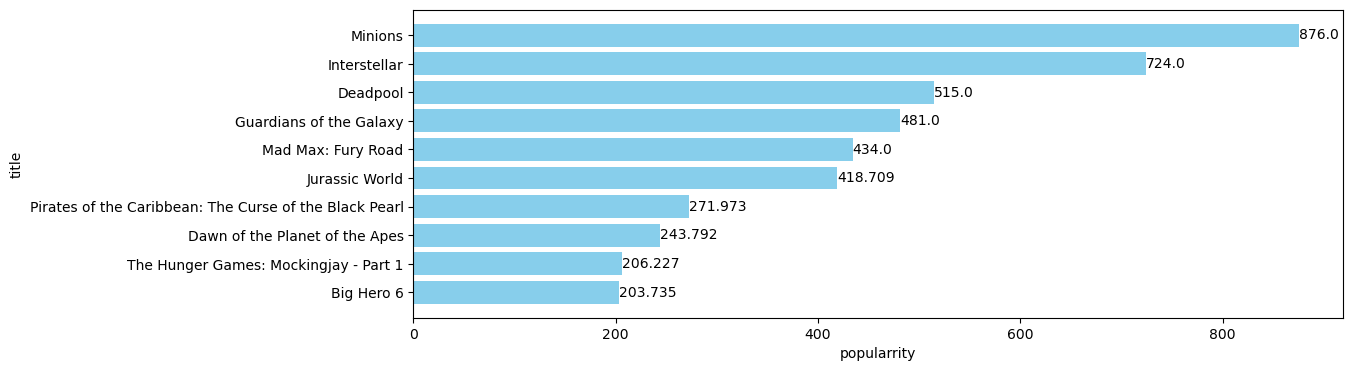

In [85]:
popularity = df2.sort_values('popularity', ascending = False)
plt.figure(figsize = (12,4))

hbars = plt.barh(popularity['title'].head(10), popularity['popularity'].head(10), align = 'center', color = 'skyblue')
plt.gca().invert_yaxis()
plt.xlabel('popularrity')
plt.ylabel('title')
plt.bar_label(hbars, popularity['popularity'].head().round())
plt.show

In [86]:
# CONTENT BASED FILTERING

In [87]:
# from sklearn.feature_extraction.text import tfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words = 'english')

df2['overview'] = df2 ['overview'].fillna('')

tfidf_matrix = tfidf.fit_transform(df2['overview'])

tfidf_matrix.shape

(4803, 20978)

In [88]:
# COSINE SILILARITY

In [89]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [90]:
indices = pd.Series(df2.index, index = df2['title']).drop_duplicates()

In [91]:
def get_recommendations(title, cosine_sim = cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    sim_scores = sorted(sim_scores, key = lambda x : x[1], reverse = True)
    
    sim_scores = sim_scores[1:11]
    
    movie_indices = [i[0] for i in sim_scores]
    
    return df2['title'].iloc[movie_indices]

In [92]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [93]:
get_recommendations('The Avengers')

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: title, dtype: object

In [94]:
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

In [101]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [107]:
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        if len(names) > 3:
            names = names[:3]
        return names
    return []

In [106]:
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(get_list)

TypeError: string indices must be integers

In [108]:
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [109]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return [str.lower(x.replace(" ", ""))]
        else:
            return ''

In [110]:
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

In [112]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' +  ' '.join(x['director']) + ' ' + ' '.join(x['genres'])

df2['soup'] = df2.apply(create_soup, axis = 1)

In [113]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words = 'english')
count_matrix = count.fit_transform(df2['soup'])

In [114]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [116]:
df2 = df2.reset_index()
indices = pd.Series(df2.index, index = df2['title'])

In [118]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object

In [119]:
get_recommendations('The Godfather', cosine_sim2)

867      The Godfather: Part III
2731      The Godfather: Part II
4638    Amidst the Devil's Wings
2649           The Son of No One
1525              Apocalypse Now
1018             The Cotton Club
1170     The Talented Mr. Ripley
1209               The Rainmaker
1394               Donnie Brasco
1850                    Scarface
Name: title, dtype: object